# Задача

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

# 1. Загрузка необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

# игнорируем замечания по поводу необновленного пакета
import warnings
warnings.filterwarnings('ignore')

# 2. Загрузка и проверка данных

In [2]:
df = pd.read_csv('~/AB_tests.csv', sep=';')

In [3]:
df.tail(3)

,user_id,revenue,testgroup
404767,404768,231,a
404768,404769,0,a
404769,404770,0,b


In [4]:
# Проверяем количество строк в датафрейме, пустые значения, типы данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [5]:
# Проверка количества уникальных user_id (совпадает с количеством строк в датасете)

df.user_id.nunique()

404770

In [6]:
# Переименуем наименования групп для удобства (на контрольную и тестовую)

dict = {'b': 'test', 'a': 'control'}
df = (df.assign(testgroup=lambda x: x['testgroup'].replace(dict)))
df.tail(2)

,user_id,revenue,testgroup
404768,404769,0,control
404769,404770,0,test


# 3. Расчет метрик

In [7]:
# Проверим количество уникальных пользователей и выручку по ним в каждой группе

all_users = df.groupby('testgroup')\
              .agg({'user_id': 'nunique', 'revenue': 'sum'})\
              .rename(columns={'user_id': 'users'})\
              .reset_index()
all_users

,testgroup,users,revenue
0,control,202103,5136189
1,test,202667,5421603


In [8]:
# Посчитаем ARPU для каждой группы

all_users['ARPU'] = (all_users['revenue'] / all_users['users']).round(2)
all_users
# Видим, что в группе test средний чек на пользователя больше

,testgroup,users,revenue,ARPU
0,control,202103,5136189,25.41
1,test,202667,5421603,26.75


In [9]:
# Посчитаем количество платящих пользователей в каждой группе

pay_users = df.query('revenue!=0')\
              .groupby('testgroup')\
              .agg({'user_id': 'nunique'})\
              .rename(columns={'user_id': 'pay_users'})\
              .reset_index()
pay_users

,testgroup,pay_users
0,control,1928
1,test,1805


In [10]:
# Посчитаем долю платящих пользователей среди всех пользователей по группам

Share_pay_users = ((df.query('revenue!=0').groupby('testgroup').agg({'user_id': 'nunique'})) / 
                   (df.groupby('testgroup').agg({'user_id': 'nunique'})))\
                                           .rename(columns={'user_id': 'share_pay_users'})\
                                           .reset_index()
Share_pay_users

,testgroup,share_pay_users
0,control,0.009540
1,test,0.008906


In [11]:
# Объединим полученную информацию с рассчитанными метриками в одну таблицу

all_users = all_users.merge(pay_users, on='testgroup').merge(Share_pay_users, on='testgroup')
all_users

,testgroup,users,revenue,ARPU,pay_users,share_pay_users
0,control,202103,5136189,25.41,1928,0.009540
1,test,202667,5421603,26.75,1805,0.008906


In [12]:
# Проверим ARPPU для каждой группы

all_users['ARPPU'] = (all_users['revenue'] / all_users['pay_users']).round(2)
all_users
# Видим, что в группе test средний чек на платящего пользователя больше

,testgroup,users,revenue,ARPU,pay_users,share_pay_users,ARPPU
0,control,202103,5136189,25.41,1928,0.009540,2664.00
1,test,202667,5421603,26.75,1805,0.008906,3003.66


Поскольку группы поделены не поровну, мы можем сравнивать относительные показатели, а не абсолютные.

Для принятия правильного решения относительно лучшего набора предложений стоит проанализировать следующие метрики:
   1. ARPU — выручка, которую мы в среднем получили с пользователя для каждой группы. 
    Мы хотели бы понять, повлияли ли на изменение среднего чека пользователя различные наборы акционных предложений. 
    Мы увидели, что средний чек в тестовой группе выше, чем в контрольной, нужно выяснить: является ли этот результат стат. значимым.
   2. ARPPU - средний доход исключительно от каждого платящего клиента.
    Мы хотели бы понять, как изменились суммы среднего чека платящих клиентов в группах в зависимости от различных наборов акционных предложений. 
    Мы увидели, что в тестовой группе платящие клиенты тратят в среднем больше денег, нужно проверить, является ли этот результат стат. значимым.
   3. Share_pay_users - доля платящих пользователей в каждой группе относительно всех входящих в группу пользователей (конверсия). 
    Мы хотели бы понять, повлияли ли наборы акционных предложений на решение пользователей приобретать платные услуги. 
    Мы увидели, что платящих пользователей в контролькой группе больше, чем в тестовой, необходимо понять, является ли это наблюдение стат.значимым.
    

# 4. Подготовка к проверке гипотез, выбор тестов, тестирование

In [13]:
# Разделим датафрейм с выручкой по группам: тестовая группа и контрольная группа

test = df.query('testgroup=="test"')
control = df.query('testgroup=="control"')

In [14]:
# Посмотрим на статистику двух получившихся датафреймов

test.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,202667.0,202215.564389,116891.926690,1.0,100855.5,201821.0,303602.5,404770.0
revenue,202667.0,26.751287,287.324162,0.0,0.0,0.0,0.0,4000.0


In [15]:
control.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,202103.0,202555.909843,116802.329266,2.0,101502.5,202988.0,303559.0,404769.0
revenue,202103.0,25.413720,920.768137,0.0,0.0,0.0,0.0,37433.0


In [16]:
# Видим, что средний чек и количество игроков больше в тестовой группе, а максимальная сумма покупки и 
# разброс сумм больльше в контрольной группе

# I. ARPU

Ранее мы заметили, что средние значения выручки на пользователя (ARPU) больше в тестовой группе, чем в контрольной. 
Нам необходимо проверить, является ли различие в ARPU двух групп стат.значимым.

Для выбора теста сначала проверим некоторые условия:
 - Независимость двух выборок
 - Нормальность распределения данных
 - Равенство дисперсий

- Наши выборки независимы (значения user_id уникальны)
- Проверим выборки на нормальность распределения с помошью гистограммы

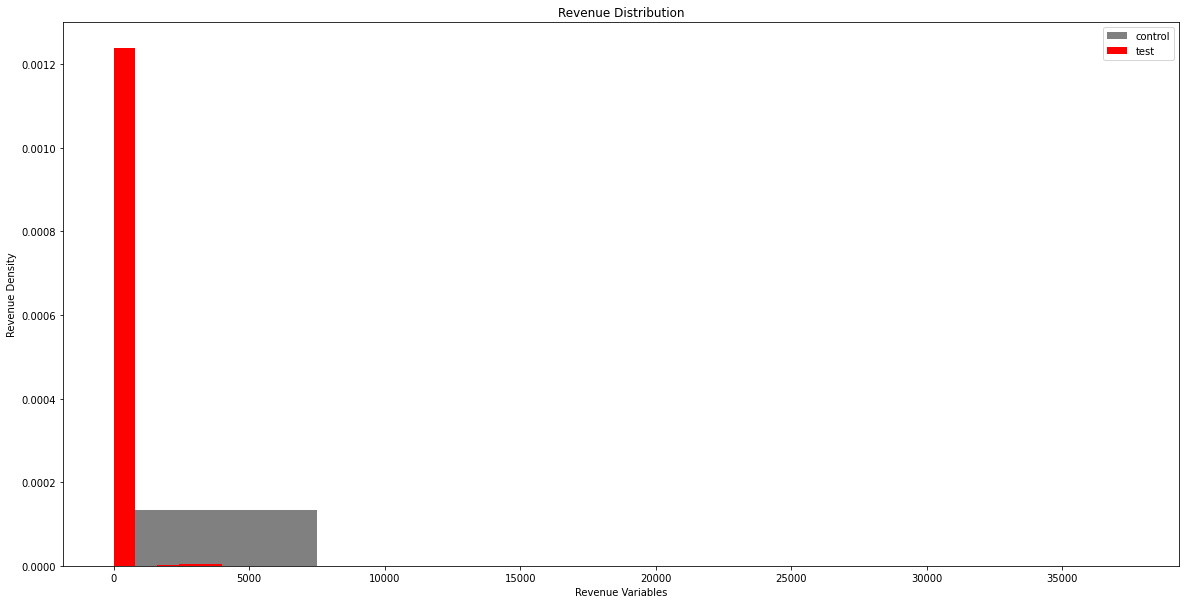

In [17]:
plt.figure(figsize=(20, 10))
plt.hist((control.revenue), density=True, color='gray', bins=5, label='control')
plt.hist((test.revenue), density=True, color='red', bins=5, label='test')
plt.title('Revenue Distribution')
plt.ylabel('Revenue Density')
plt.xlabel('Revenue Variables')
plt.legend()
plt.show()

Видно, что наборы данных не имеют нормального распределения.

Так же, видим на графике, что разброс значений в контрольной группе больше, чем в тестовой, при этом в тестовой группе больше плотность распределения. Это говорит нам о том, что пользователи тестовой группы чаще тратили крупные суммы, чем клиенты контрольной группы, хотя, при этом, самих платящих пользователей больше в контрольной группе.

In [18]:
# Перепроверим нормальность распределения с помощью теста  Шапиро-Уилка
# Нулевая гипотеза для теста Шапиро-Уилка: распределение выручки в контрольной группе соответствует нормальному

stats.shapiro(control['revenue'])

ShapiroResult(statistic=0.008876502513885498, pvalue=0.0)

In [19]:
# H0: распределение выручки в тестовой группе соответствует нормальному

stats.shapiro(test['revenue'])

ShapiroResult(statistic=0.06588172912597656, pvalue=0.0)

Поскольку pvalue в двух выборках меньше 0.05, мы отвергаем нулевую гипотезу и говорим о том, что распределение средних в каждой выборке отклоняется от нормального

- Теперь проверим данные двух групп на равенство дисперсий

Будем проверять с помощью теста Левена. Поскольку наши данные не следуют нормальному распределению (в этом мы убедились на предыдущем шаге), тест Левена предпочтительнее, чем тест Барлетта
 
 Гипотезы для теста Левена:
 
         H 0 : Дисперсии выручки относительно среднего значения в двух группах равны
         H 1 : Дисперсии свыручки относительно среднего значения в двух группах отличаются

In [20]:
stats.levene(control['revenue'], test['revenue'], center='mean')

LeveneResult(statistic=1.57736044973474, pvalue=0.2091420343022563)

Поскольку pvalue больше 0.05, мы не сможем отвергнуть нулевую гипотезу и принимаем, что дисперсии в двух группах для ARPU равны. 

В этом случае для сравнения средних в двух группах, несмотря на ненормальность распределения данных, мы сможем применить т-тест, поскольку имеем дело с большими выборками, у которых равны дисперсии.

- Тестирование гипотезы с помощью ttest

Гипотезы для t-теста для двух выборок: 

    H 0 : Различия в ARPU в тестовой и контрольной группе не являются стат.значимыми.
    H A : ARPU в тестовой и контрольной группе различаются статистически значимо.

In [21]:
stats.ttest_ind(control['revenue'], test['revenue'], equal_var=True)

Ttest_indResult(statistic=-0.6242026493616787, pvalue=0.532494858971837)

Мы получили pvalue больше 0.05, это значит, что мы не можем отклонить нулевую
гипотезу о том, что различия ARPU двух групп не являются статистически значимыми. 

# II. ARPPU

Ранее мы заметили, что средние значения выручки на платящего пользователя (ARPPU) больше в тестовой группе, чем в контрольной. 
Нам необходимо проверить, является ли различие в ARPPU двух групп стат.значимым.

Для выбора теста сначала проверим некоторые условия:
 - Независимость двух выборок
 - Нормальность распределения данных
 - Равенство дисперсий

- Наши выборки независимы (значения user_id уникальны)
- Проверим выборки на нормальность распределения с помошью qqplot, который показывает, насколько выборочные значения хорошо соответствуют предсказанным значениям, если бы наше распределение было идеально нормальным

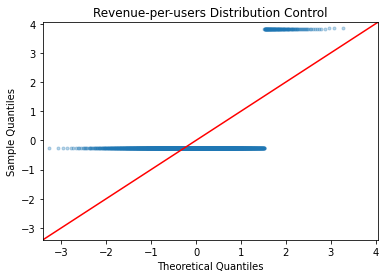

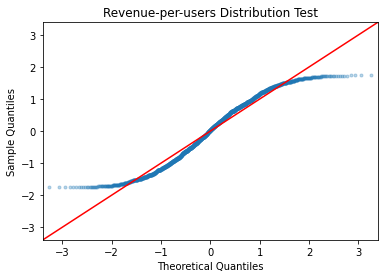

In [22]:
sm.qqplot((control.query('revenue>0').revenue), alpha=0.3, line='45', marker='.', fit=True)
plt.title('Revenue-per-users Distribution Control')
plt.show()

sm.qqplot((test.query('revenue>0').revenue), alpha=0.3, line='45', marker='.', fit=True)
plt.title('Revenue-per-users Distribution Test')
plt.show()

Видно, что оба набора данных не имеют нормального распределения. 

При этом, разброс значений в контрольной группе больше, чем в тестовой (это видно по тому, как много точек контрольной групы находятся далеко от средней линии).

- Теперь проверим данные двух групп на равенство дисперсий

Будем проверять с помощью теста Левена. Поскольку наши данные не следуют нормальному распределению (в этом мы убедились на предыдущем шаге), тест Левена предпочтительнее, чем тест Барлетта
 
 Гипотезы теста Левена:
 
     H 0 : Дисперсии выручки от платящих пользователей в двух группах равны
     H 1 : Дисперсии выручки от платящих пользователей в двух группах отличаются

In [23]:
stats.levene((control.query('revenue>0').revenue), (test.query('revenue>0').revenue), center='mean')

LeveneResult(statistic=445.9869447066088, pvalue=1.3202514573715939e-93)

Поскольку pvalue меньше 0.05, мы сможем отвергнуть нулевую гипотезу о том, что дисперсии совокупности в двух группах для ARPPU равны. 

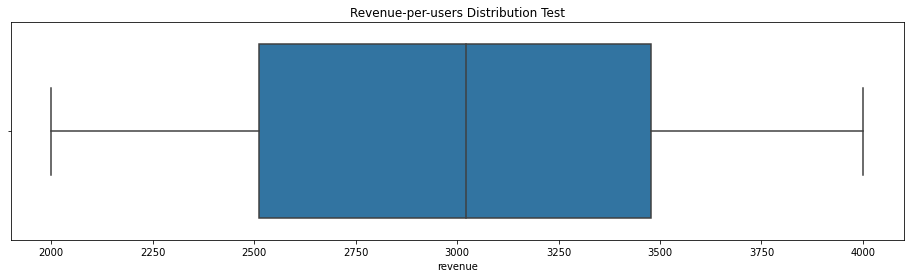

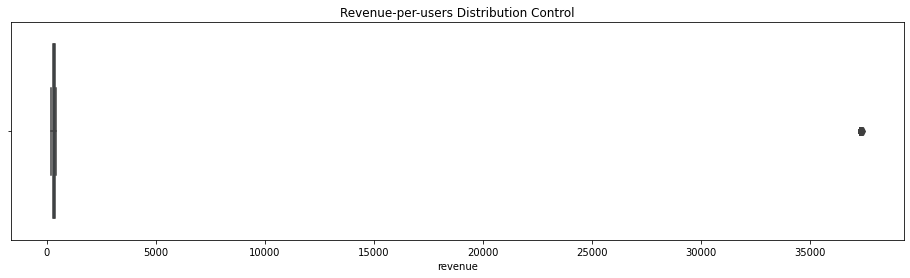

In [24]:
# Еще раз посмотрим на распредления средних чеков платящих пользователей в двух группах

fig, ax = plt.subplots(figsize=(16, 4))
plt.title('Revenue-per-users Distribution Test')
sns.boxplot(x = test.query('revenue>0').revenue);
plt.show()

fig, ax = plt.subplots(figsize=(16, 4))
plt.title('Revenue-per-users Distribution Control')
sns.boxplot(x = control.query('revenue>0').revenue);
plt.show()

In [25]:
# Поскольку выборки содержат выбросы, посмотрим на медианы в тестовой и контрольных группах

test.query('revenue>0').revenue.median()

3022.0

In [26]:
control.query('revenue>0').revenue.median()

311.0

Видим, что медианы в двух группах сильно отличаются.

Кроме того, мы можем видеть, что 123 клиента контрольной группы совершили крупные покупки на суммы более 37 000, что в совокупности принесло 89% всей выручки группы, при том, что это менее 1% всех клиентов группы и всего 6% от платящих пользователей группы. 

В то время, как 51% платящих пользователей тестовой группы совершили покупки на суммы от 3 000, что в совокупности составило 51% от всей выручки группы.

Это наблюдение наталкивает на мысль, что сплитование групп проведено некорректно, т.к. все крупные клиенты собрались в контрольной группе, возможно, это оптовые клиенты, а в тестовой - розничные. 

In [27]:
print(test.query('revenue>3000').user_id.count()) #test
print(control.query('revenue>37000').user_id.count()) #control

922
123


In [28]:
print(922*3000/5421603) #test
print(123*37000/5136189) #control

0.5101812139324845
0.8860655244579201


 - При неравенстве дисперсий мы не сможем применить t-критерий Стьюдента для проверки гиспотезы про ARPPU. 
 - В этом случае мы могли бы применить t-критерий Уэлча, который аналогичен независимому t-тесту для двух выборок, за исключением того, что он не предполагает, что две выборки, имеют одинаковую дисперсию. Однако, из-за появления выбросов в группах, происходит смещение среднего. В таком случае, есть риск, что t-критерий Уэлча, проведенный в данных, распределенных не нормально, сработает некорректно. 
 - Поэтому проверим гипотезу о равенстве ARPPU в двух группах с помощью метода Bootstrap, используя в качестве статистики медиану, а не среднее.

Гипотезы для метода Bootstrap:
    - H 0 : ARPPU в тестовой и контрольной группах не различаются статистически значимо.
    - H A : ARPPU в тестовой и контрольной группе различаются статистически значимо.

In [29]:
''' Записываем в каждом результате нашей симуляции разницу между медианами
Строим доверительный интервал для разницы, полученной при многократном повторении эксперимента'''

median_diff = []

for i in range(10000):
    sample_data_test = (test.query('revenue>0')).sample(frac=1, replace=True)
    sample_median_test = sample_data_test.revenue.median()
    
    
    sample_data_control = (control.query('revenue>0')).sample(frac=1, replace=True)
    sample_median_control = sample_data_control.revenue.median()
    
    sample_median_diff = sample_median_test - sample_median_control
    median_diff.append(sample_median_diff)

In [30]:
pd.Series(median_diff).quantile(0.975)

2760.0

In [31]:
pd.Series(median_diff).quantile(0.025)

2657.9875

Text(0, 0.5, 'Distribution Density')

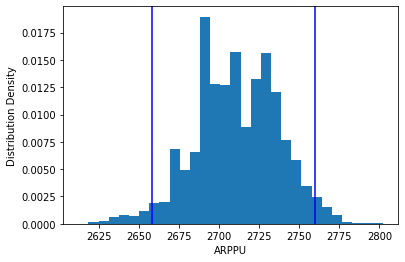

In [32]:
# Визуализируем на графике доверительный интервал

plt.hist(median_diff, bins=30, density=True)
plt.axvline(pd.Series(median_diff).quantile(0.975), color='b')
plt.axvline(pd.Series(median_diff).quantile(0.025), color='b')

plt.xlabel('ARPPU')
plt.ylabel('Distribution Density')

Получаем, что разница медиан находится в диапазоне от 2658 до 2760, этот диапазон не включает в себя 0, т.е. разница между медианами положительная и она статистически значима на уровне 5%, поэтому мы говорим, что ARPPU двух групп стат.значимо отлиаются

# III. Share_pay_users

При исследовании вопроса о доле платящих пользователях, мы имеем дело с категориальными переменными: человек либо платит, либо нет. Вторая категориальная величина - это принадлежность к группе. Для проверки гипотез о том, равны ли у двух категориальных величин распределения, используется Критерий Хи-квадрат. 

Есть всего два важных условия использования критерия:
    
    - Все наблюдения независимы;
    - Количество наблюдений в каждой ячейке больше 5.
Оба условия выполняются для наших выборок.

В данном случае нас интересует вопрос однородности распределения платящих клиентов по группам (тестовой и контрольной). Ранее, при расчете метрик, мы увидели, что платящих пользователей в контролькой группе больше, чем в тестовой, необходимо статистически обосновать или опровергнуть это наблюдение.

Гипотезы для Критерия Хи-квадрат (однородности Пирсона):
    - H0: Распределение платящих пользователей в двух группах идентично
    - H1: Распределение платящих пользователей в двух группах отличаются.

In [33]:
df.tail(2)

,user_id,revenue,testgroup
404768,404769,0,control
404769,404770,0,test


В основном датафрейме создадим колонку, в которой, для каждого клиента, зафиксируем, является он платящим ('pay'), или нет ('no_pay')

In [34]:
df['solvency'] = np.where((df.revenue > 0), 'pay', 'no_pay')
df.tail(3)

,user_id,revenue,testgroup,solvency
404767,404768,231,control,pay
404768,404769,0,control,no_pay
404769,404770,0,test,no_pay


In [35]:
# Создание таблицы сопряженности

contingency_table = pd.crosstab(df['solvency'], df['testgroup'])
print(contingency_table)

testgroup  control    test
solvency                  
no_pay      200175  200862
pay           1928    1805


In [36]:
# Расчет критерия Пирсона

chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f"χ²: {chi2}, p-значение: {p}")

χ²: 4.374729521260405, p-значение: 0.03647561892312613


Значение p_value ниже 0.05, значит мы отвергаем нулевую гипотезу об однородности распределения. И принимаем вывод, что для контрольной и тестовой групп имеются различия в распределении количества платящих пользователей.

# 5. ВЫВОД:

 - В результате проведенного анализа мы не смогли отклонить нулевую гипотезу о том, что ARPU в двух группах равны. Следовательно, мы считаем, что различные наборы акционных предложений в целом не повлияли на лояльность клиентов какой-либо из групп больше, чем на вторую.
 
 - В то же время, на основании проведенного анализа ARPPU с помощью метода bootstrap удалось отклонить нулевую гипотезу о том, что различия в ARPPU в двух группах не являются статистически значимыми. Из чего можно было бы сделать вывод, что различные наборы акционных предложений повлияли стат. значимо на поведение платящего пользователя (ARPPU в тестовой группе больше, чем в контрольной).
 - При этом, с помощью критерия хи-квадрат удалось  выяснить, что платящих пользователей в контрольной группе больше, чем в тестовой. Получается, что ARPPU больше в тестовой группе не за счет количества платящих клиентов, которых привлекло предложение, а за счет сумм, которые некоторые клиенты готовы платить.
 - С точки зрения бизнеса, нам интереснее, чтобы как можно больше пользователей платили, и суммы их чеков были выше. Но новые наборы акционных предложений не принесли совокупного эффекта в одной из групп. ARPPU вырос за счет меньшей конверсии пользователя в платящего клиента и большего количества крупных сумм оплат, а вырука контрольной группы складывается из 123 оптовых клиентов и множества небольших сумм, но при этом, большей конверсии в платящего пользователя. 
 - Если выбирать из двух, то нужно посмотреть на абсолютные показатели, и получается, что совокупный доход в тестовой группе больше при меньшей себестоимости в части расходов на обслуживание платящих клиентов, т.к. их меньше. 
Поэтому, если говорить о выборе набора акционных предложений, то мы должны выбрать тот набор, который был применен к тестовой группе (b).

 - Однако, в ходе анализа данных нам удалось заметить, что в двух группах разные, непересекающиеся сегменты пользователей по величине оплат (в контрольной группе есть 123 оптовых клиента, которых нет в тестовой, эти клиенты делают 89% выручки контрольной группы), и, вероятно, что дизайн эксперимента нарушен и сплитование проведено некорректно.
 При таком положении вещей стоит засомневаться в корректности проведенного эксперимента и стоит пересобрать группы и повторного запустить эксперимент.